In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# 1.构建图

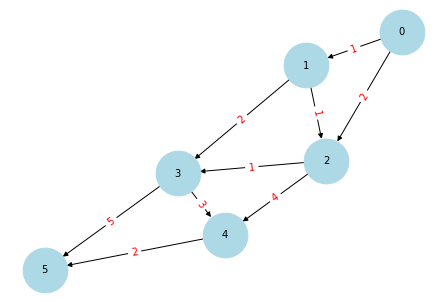

In [10]:
# 创建有向图
G = nx.DiGraph()

# 添加带权重的边
edges = [
    (0, 1, 1), (0, 2, 2), (1, 2, 1), (1, 3, 2), (2, 3, 1),
    (3, 4, 3), (2, 4, 4), (4, 5, 2), (3, 5, 5), 
]
G.add_weighted_edges_from(edges)


# 绘制图
pos = nx.spring_layout(G)  # 使用Spring布局
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): G[u][v]['weight'] for u, v in G.edges()}, font_color='red')

# 显示图
plt.show()


# 2.使用networkX查找最短路径

In [11]:
from itertools import islice
def k_shortest_paths(G, source, target, k, weight=None):
    return list(islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))

In [12]:
# 获取 k-最短路径
paths = k_shortest_paths(G, 0, 5, 3, 'weight')

# 输出路径和权重
for i, path in enumerate(paths):
    weight = sum(G[path[n]][path[n + 1]]['weight'] for n in range(len(path) - 1))
    print(f"Path {i + 1}: {path}, weight: {weight}")


Path 1: [0, 1, 3, 5], weight: 8
Path 2: [0, 2, 3, 5], weight: 8
Path 3: [0, 1, 2, 3, 5], weight: 8


# 3.自己构建方法

In [19]:
from itertools import count
from heapq import heappush, heappop
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt

class K_shortest_path(object):
    def __init__(self,G,  k=3, weight='weight') -> None:
        self.G = G 
        self.k = k
        self.weight = weight
        self.G_original = G
        
    def get_path_length(self,G,path:list, weight='weight'):
        """计算每条路径的总阻抗，基于weight
        Args:
            G (nx.graph): 构建的图
            path (list): 路径
            weight (str, optional): 边的权重计算基于什么，可以是时间也可以是距离. Defaults to 'weight'.
        """
        length = 0
        if len(path) > 1:
            for i in range(len(path) - 1):
                u = path[i]
                v = path[i + 1]
                length += G.edges[u,v].get(weight, 1)
        return length     
    
    def find_sp(self,s,t,G):
        """找到第一条P(1)

        Args:
            s (node): 路径起点
            t (node): 路径终点
        
        lenght:P(1)对应的长度
        path:P(1)对应的路径 list
        """
        path_1 = nx.shortest_path(G=G,source=s,target=t,weight=self.weight)
        length_1 = nx.shortest_path_length(G=G,source=s,target=t,weight=self.weight)
        # length_1, path_1 = nx.single_source_dijkstra(G,source=s,weight=weight)

        return length_1, path_1
    
    
    def find_Pi_sp(self,source,target):
        if source == target:
            return ([0], [[source]]) 
        G =  self.G
        k = self.k
        length, path = self.find_sp(G=G,s=source,t=target)
        lengths = []
        paths = []
        lengths.append(length)
        paths.append(path)
        c = count()        
        B = [] 
        G_original = self.G.copy()   
         
        for i in range(1, k):
            for j in range(len(paths[-1]) - 1):            
                spur_node = paths[-1][j]
                root_path = paths[-1][:j + 1]
                
                edges_removed = []
                for c_path in paths:
                    if len(c_path) > j and root_path == c_path[:j + 1]:
                        u = c_path[j] #节点
                        v = c_path[j + 1] #节点
                        if G.has_edge(u, v):  #查看u，v节点之间是否有路径
                            edge_attr = G.edges[u,v]['weight']
                            G.remove_edge(u, v) #移除边
                            edges_removed.append((u, v, edge_attr))
                            
                for n in range(len(root_path) - 1):
                    node = root_path[n]
                    # out-edges
                    dict_d = []
                    for (u,v,edge_attr) in G.edges(nbunch =node,data = True ):
                    # for u, v, edge_attr in G.edges_iter(node, data=True):
                        edge_attr = edge_attr['weight']
                        dict_d.append((u,v))
                        edges_removed.append((u, v, edge_attr))
                    G.remove_edges_from(dict_d) 
                        
                        
                    if G.is_directed():
                        # in-edges
                        in_edges_d_list = []
                        for (u,v,edge_attr) in G.edges(nbunch =node,data = True ):
                        # for u, v, edge_attr in G.in_edges_iter(node, data=True):
                            # edge_attr = edge_attr['weight']
                            edge_attr = G.edges[u,v]['weight']
                            # G.remove_edge(u, v)
                            in_edges_d_list.append((u,v))
                            edges_removed.append((u, v, edge_attr))
                        G.remove_edges_from(in_edges_d_list) 
                        
                spur_path_length, spur_path = nx.single_source_dijkstra(G, spur_node, weight=self.weight)            
                
                if target in spur_path and spur_path[target]:
                    total_path = root_path[:-1] + spur_path[target]
                    
                    total_path_length = self.get_path_length(G_original, root_path, self.weight) + spur_path_length[target]                
                    
                    heappush(B, (total_path_length, next(c), total_path))
                    
                for e in edges_removed:
                    u, v, edge_attr = e
                    G.add_edge(u, v, weight = edge_attr)
                            
            if B:
                (l, _, p) = heappop(B)        
                lengths.append(l)
                paths.append(p)
            else:
                break
        return (lengths,paths)
    
          

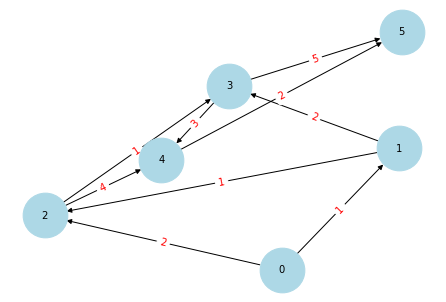

  weight             path
0      8     [0, 1, 3, 5]
1      8     [0, 2, 3, 5]
2      8  [0, 1, 2, 3, 5]


In [22]:
  
if __name__ =='__main__':
    # 创建有向图
    G = nx.DiGraph()

    # 添加带权重的边
    edges = [
        (0, 1, 1), (0, 2, 2), (1, 2, 1), (1, 3, 2), (2, 3, 1),
        (3, 4, 3), (2, 4, 4), (4, 5, 2), (3, 5, 5), 
    ]
    G.add_weighted_edges_from(edges)
    for u, v, weight in edges:
        G.add_edge(u, v, weight=weight)
    
    KSP = K_shortest_path(G=G,k=3,weight='weight')
    KSP.G
    
    # 绘制图
    pos = nx.spring_layout(KSP.G)  # 使用Spring布局
    nx.draw(KSP.G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10)
    nx.draw_networkx_edge_labels(KSP.G, pos, edge_labels={(u, v): KSP.G[u][v]['weight'] for u, v in KSP.G.edges()}, font_color='red')
    # 显示图
    plt.show()
    
    # 最短路径查询
    source = 0
    target = 5
    (lengths,paths) = KSP.find_Pi_sp(source=source,target=target)
    k_df = pd.DataFrame((lengths,paths)).T
    k_df.columns = ['weight','path']
    print(k_df)